In [1597]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stock_module as sm
import random
import os
import datetime
import time
import openpyxl
from sklearn.preprocessing import scale
from scipy.signal import savgol_filter
from scipy.signal import lfilter

In [1604]:
def remove_noise(frame, first_par, second_par):
    w_out_noise = savgol_filter(frame["StockValue"], first_par, second_par)
    frame["StockValue"] = w_out_noise
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [1603]:
n = 15  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
def remove_noise_lFilter(frame, b, a):
    w_out_noise_lFilter = lfilter(b, a, frame["StockValue"])
    frame["StockValue"] = w_out_noise_lFilter
    frame_f = frame[["StockValue"]]
    # frame_f = frame_f.rename(columns={"StockValue": "StockValue_wo_noisede"})
    return frame_f

In [5]:
def ma_columns(frame_column, list_ma):
    MAs = [] 
    for ma in list_ma:
        MA = pd.DataFrame(sm.short_moving_average(frame_column, ma)["StockValue"]).rename(columns={"StockValue": f"MA_{ma}"})
        MAs.append(MA)
        
    frame = MAs[0].join(MAs[1])
    for i in range(len(MAs)-2):
        frame = frame.join(MAs[i+2])
    
    frame = frame.dropna()
    
    return frame

In [1459]:
def buy_sell_recommendations(new_frame):
    ### ma_50_200 farkı sıfırdan büyük veya 5 günlük trajectory değeri sıfırdan büyükse;
    #### MA_7_50 farkı sıfıra eşit veya büyükse devamını uygula
    #### MA_7_50 farkı sıfırdan küçükse devamını uygula
    new_frame['rec_1'] = np.where((((new_frame["MA_50_200"]>-0.1) | (new_frame["MA_50_200_CH"]>0)))
                                  # & (new_frame["StockValue"] > new_frame["StockValue_WoN"] * 0.90))
                                  & (((new_frame['MA_7_50']>=0) & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*0.75))
                                  | ((new_frame['MA_7_50']<0) & (new_frame['MA_7_50']*1 > new_frame["MA_50_200"]*1)))
                                         ,"BUY", "SELL")
    
    new_frame['rec_2'] = np.where((((new_frame["MA_50_200"]>-0.01) | (new_frame["MA_50_200_CH"]>0)))
                                  # & (new_frame["StockValue"] > new_frame["StockValue_WoN"] * 0.90))
                                  & (((new_frame['MA_14_100']>=0) & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*0.8))
                                  | ((new_frame['MA_14_100']<0) & (new_frame['MA_14_100']*1 > new_frame["MA_50_200"]*1)))
                                     ,"BUY", "SELL")
    
    return new_frame

In [7]:
def get_locations(new_frame):
    loc_first=[]
    for row in range(new_frame.shape[0]-1):

            if new_frame.iloc[row,:].rec_1 == "SELL":
                if new_frame.iloc[row+1,:].rec_1 == "BUY":
                    start = row+1
                    loc_first.append(start)

            if new_frame.iloc[row,:].rec_1 == "BUY":
                if new_frame.iloc[row+1,:].rec_1 == "SELL":
                    end = row+2
                    loc_first.append(end)
                    
    loc_second=[]
    for row in range(new_frame.shape[0]-1):

        if new_frame.iloc[row,:].rec_2 == "SELL":
            if new_frame.iloc[row+1,:].rec_2 == "BUY":
                start = row+1
                loc_second.append(start)

        if new_frame.iloc[row,:].rec_2 == "BUY":
            if new_frame.iloc[row+1,:].rec_2 == "SELL":
                end = row+2
                loc_second.append(end)
                
    return [loc_first, loc_second]

In [8]:
def get_transactions(new_frame, column, locations):
    if new_frame.iloc[0,:][str(column)] == "SELL":
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(0,len(locations),2), range(1,len(locations),2))]
    else:
        transactions = [[locations[buy], locations[sell]] for buy, sell in zip(range(1,len(locations),2), range(2,len(locations),2))]
        transactions.insert(0, [0, locations[0]])

    return transactions

In [9]:
def returns(new_frame, list_of_transactions):
    returns = []
    for transactions in list_of_transactions:
        buy = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[0]
        sell = list(new_frame.iloc[transactions[0]:transactions[1],:]["StockValue"])[-1]
        ret = (sell-buy)/buy
        returns.append(ret)
    
    return returns

In [10]:
def prod(list_of_all_returns):
    return np.prod([ret+1 for ret in list_of_all_returns]) 

In [11]:
def get_only_frame(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [1782]:
def convert_date(date):
    return datetime.datetime.strptime(date, "%d-%m-%Y")

In [1783]:
def convert_str_from_date(date: str):
    return datetime.datetime.strftime(date, "%d-%m-%Y")

In [1784]:
def increment_date(date:str, increment_day:int):
    date = convert_date(date)
    date = date + datetime.timedelta(days=increment_day)
    date = convert_str_from_date(date)
    
    return date

In [162]:
increment_date("01-01-2015", 2)

'03-01-2015'

In [16]:
def simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)
    
    frame_f = remove_noise(frame, noise_first_par, noise_second_par)
    new_frame = ma_columns(frame_f, ma_list)
    
    new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    frame = pd.read_pickle(stock_name)
    frame = frame[["HGDG_TARIH", "StockValue"]]
    new_frame = new_frame.join(frame)
    
    new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    loc_first = get_locations(new_frame)[0]
    loc_second = get_locations(new_frame)[1]
    
    first_transactions = get_transactions(new_frame, "rec_1", loc_first)
    second_transactions = get_transactions(new_frame, "rec_2", loc_second)

    first_returns = returns(new_frame, first_transactions)
    second_returns = returns(new_frame, second_transactions)
    
    first_cum_return = prod(first_returns)
    print(f"Final position of first transactions : {first_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in first_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of first transactions        : {[round(first,3) for first in first_returns]}")
    print(f"Locations of first transactions      : {first_transactions}")
    print("-"*85)
    
    second_cum_return  = prod(second_returns)
    print(f"Final position of second transactions: {second_cum_return}")
    print(f"Duration (days) - total length       : {sum([t[1]-t[0] for t in second_transactions])} - {new_frame.shape[0]}")
    print(f"Returns of second transactions       : {[round(second,3) for second in second_returns]}")
    print(f"Locations of second transactions     : {second_transactions}")
    print("-"*85)

    totalReturn = (first_cum_return + second_cum_return) / 2
    print(f"Ultimate position : {totalReturn}")
    
    return totalReturn

---

In [1908]:
def get_only_frame_simulation(stock_name, start_date, end_date, ma_list, noise_first_par, noise_second_par):
    
    frame = pd.read_pickle(stock_name)
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    frame = frame[(frame.HGDG_TARIH < end_date) & (frame.HGDG_TARIH > start_date)]
    date = frame[["HGDG_TARIH"]]
    
    # new_frame = remove_noise(frame, noise_first_par, noise_second_par)           # SAVGOL FILTER
    new_frame = remove_noise_lFilter(frame, noise_first_par, noise_second_par)     # LFILTER
    # new_frame.iloc[-500:,:]["StockValue"] = scale(new_frame.iloc[-500:,:]["StockValue"])
    
    # new_frame = ma_columns(frame_f, ma_list)
    
    # new_frame["MA_7_50"] = new_frame["MA_7"] - new_frame["MA_50"]
    # new_frame["MA_14_100"] = new_frame["MA_14"] - new_frame["MA_100"]
    # new_frame["MA_50_200"] = new_frame["MA_50"] - new_frame["MA_200"]
    
    # frame = pd.read_pickle(stock_name)
    # new_frame = new_frame[["HGDG_TARIH", "StockValue"]]
    # new_frame = new_frame.join(frame)
    
    # new_frame = buy_sell_recommendations(new_frame)
    new_frame = new_frame.join(date)
    new_frame = new_frame.rename(columns={"HGDG_TARIH": "Date"})
    
    return new_frame

In [1909]:
def extract_and_store(stock_name, start_date, end_date):
    frame = sm.extract_stock_values(start_date, end_date, [stock_name])
    frame = frame.drop_duplicates(subset=["HGDG_HS_KODU", "HGDG_TARIH"], keep="last")
    frame = frame.rename(columns={"HGDG_KAPANIS": "StockValue"})
    frame = frame.sort_values(by=["HGDG_TARIH"])
    frame = frame.reset_index(drop=True)
    frame.to_pickle(stock_name)

In [1934]:
stock_name = "PGSUS"
ma_list=[7,14,50,100,200]
#noise_first_par = 51
#noise_second_par = 2

n = 15  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
noise_first_par = b
noise_second_par = a

general_startDate = "31-01-2000"
general_endDate = "31-12-2020"

start_date = "01-01-2011"
first_end_date = "01-02-2018"
final_last_date = "01-07-2020"

In [1935]:
# extract stock values and store
extract_and_store(stock_name, general_startDate, general_endDate)

In [1936]:
observations = []
for i in range(900):
    frame = pd.read_pickle(stock_name)
    print(first_end_date)
    if frame[frame["HGDG_TARIH"] == first_end_date].shape[0] == 1:
        frame = get_only_frame_simulation(stock_name, start_date, first_end_date, ma_list, noise_first_par, noise_second_par)
        observations.append(frame.iloc[-1,:])
    else:
        observations = observations
    first_end_date = increment_date(first_end_date, 1)

final_frame = pd.concat(observations, axis=1)
final_frame = final_frame.T
final_frame = final_frame.drop_duplicates(subset=["Date"])

new_frame = ma_columns(final_frame, ma_list)
final_frame = final_frame.join(new_frame)
final_frame = final_frame.dropna()

final_frame["MA_7_50"] = final_frame["MA_7"] - final_frame["MA_50"]
final_frame["MA_14_100"] = final_frame["MA_14"] - final_frame["MA_100"]
final_frame["MA_50_200"] = final_frame["MA_50"] - final_frame["MA_200"]

trajectory = sm.trajectory(final_frame[["MA_50_200"]], 5)[["MA_50_200_CH"]]
final_frame = final_frame.join(trajectory)

# final_frame["MA_50_200"] = scale(final_frame["MA_50_200"]) # SCALING ZAMANA GÖRE YAP
# final_frame["MA_14_100"] = scale(final_frame["MA_14_100"])
# final_frame["MA_7_50"] = scale(final_frame["MA_7_50"])

# final_frame = buy_sell_recommendations(final_frame)
final_frame = final_frame.rename(columns={"StockValue": "StockValue_WoN"})

frame = pd.read_pickle(stock_name)
frame = frame[["StockValue"]]
final_frame = final_frame.join(frame)

final_frame = final_frame.dropna()
final_frame = buy_sell_recommendations(final_frame)

01-02-2018
02-02-2018
03-02-2018
04-02-2018
05-02-2018
06-02-2018
07-02-2018
08-02-2018
09-02-2018
10-02-2018
11-02-2018
12-02-2018
13-02-2018
14-02-2018
15-02-2018
16-02-2018
17-02-2018
18-02-2018
19-02-2018
20-02-2018
21-02-2018
22-02-2018
23-02-2018
24-02-2018
25-02-2018
26-02-2018
27-02-2018
28-02-2018
01-03-2018
02-03-2018
03-03-2018
04-03-2018
05-03-2018
06-03-2018
07-03-2018
08-03-2018
09-03-2018
10-03-2018
11-03-2018
12-03-2018
13-03-2018
14-03-2018
15-03-2018
16-03-2018
17-03-2018
18-03-2018
19-03-2018
20-03-2018
21-03-2018
22-03-2018
23-03-2018
24-03-2018
25-03-2018
26-03-2018
27-03-2018
28-03-2018
29-03-2018
30-03-2018
31-03-2018
01-04-2018
02-04-2018
03-04-2018
04-04-2018
05-04-2018
06-04-2018
07-04-2018
08-04-2018
09-04-2018
10-04-2018
11-04-2018
12-04-2018
13-04-2018
14-04-2018
15-04-2018
16-04-2018
17-04-2018
18-04-2018
19-04-2018
20-04-2018
21-04-2018
22-04-2018
23-04-2018
24-04-2018
25-04-2018
26-04-2018
27-04-2018
28-04-2018
29-04-2018
30-04-2018
01-05-2018
02-05-2018

03-03-2020
04-03-2020
05-03-2020
06-03-2020
07-03-2020
08-03-2020
09-03-2020
10-03-2020
11-03-2020
12-03-2020
13-03-2020
14-03-2020
15-03-2020
16-03-2020
17-03-2020
18-03-2020
19-03-2020
20-03-2020
21-03-2020
22-03-2020
23-03-2020
24-03-2020
25-03-2020
26-03-2020
27-03-2020
28-03-2020
29-03-2020
30-03-2020
31-03-2020
01-04-2020
02-04-2020
03-04-2020
04-04-2020
05-04-2020
06-04-2020
07-04-2020
08-04-2020
09-04-2020
10-04-2020
11-04-2020
12-04-2020
13-04-2020
14-04-2020
15-04-2020
16-04-2020
17-04-2020
18-04-2020
19-04-2020
20-04-2020
21-04-2020
22-04-2020
23-04-2020
24-04-2020
25-04-2020
26-04-2020
27-04-2020
28-04-2020
29-04-2020
30-04-2020
01-05-2020
02-05-2020
03-05-2020
04-05-2020
05-05-2020
06-05-2020
07-05-2020
08-05-2020
09-05-2020
10-05-2020
11-05-2020
12-05-2020
13-05-2020
14-05-2020
15-05-2020
16-05-2020
17-05-2020
18-05-2020
19-05-2020
20-05-2020
21-05-2020
22-05-2020
23-05-2020
24-05-2020
25-05-2020
26-05-2020
27-05-2020
28-05-2020
29-05-2020
30-05-2020
31-05-2020
01-06-2020

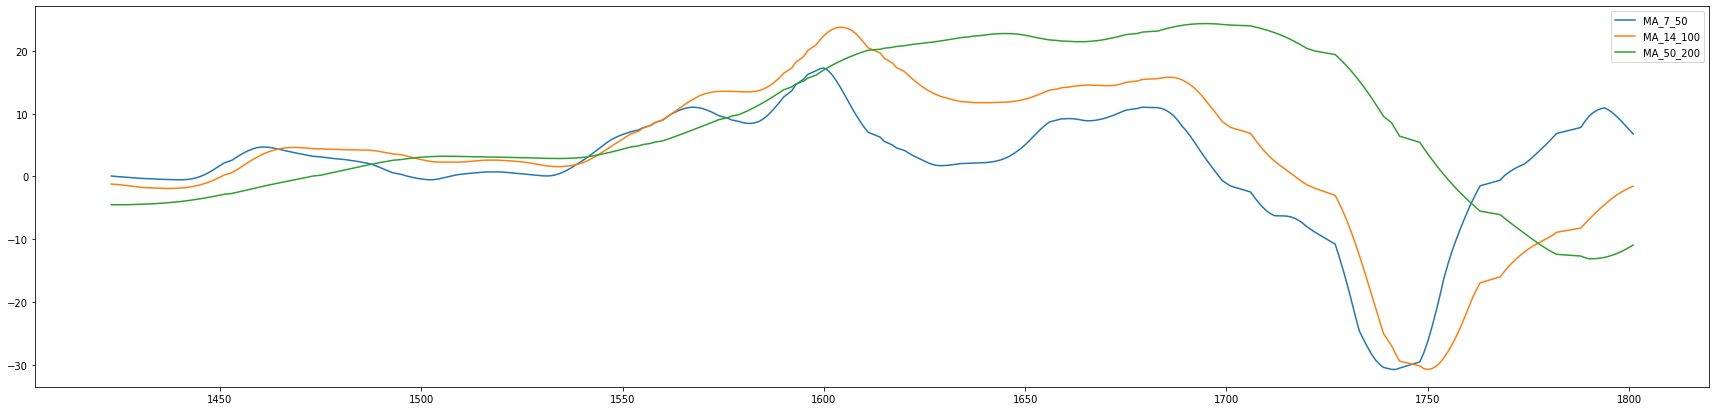

In [1937]:
final_frame.iloc[:,:][["MA_7_50","MA_14_100","MA_50_200"]].plot(figsize=(30,7))

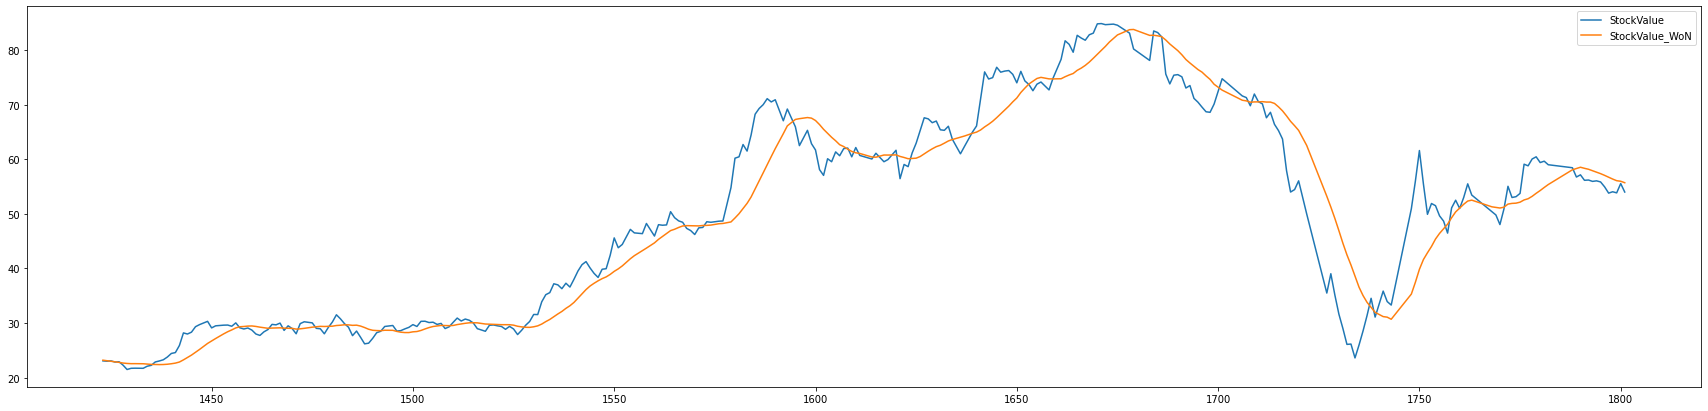

In [1938]:
final_frame.iloc[:,:][["StockValue", "StockValue_WoN"]].plot(figsize=(30,7))

In [1957]:
final_frame.iloc[47:64,:]

,StockValue_WoN,Date,MA_7,MA_14,MA_50,MA_100,MA_200,MA_7_50,MA_14_100,MA_50_200,MA_50_200_CH,StockValue,rec_1,rec_2
1472,28.9493,2019-03-05,29.034857,29.149619,25.705360,24.675013,25.795213,3.329497,4.474606,-0.089853,-0.324586,29.90,BUY,SELL
1473,29.0373,2019-03-06,29.025714,29.120095,25.819227,24.700013,25.772340,3.206488,4.420082,0.046887,-0.594730,30.24,BUY,BUY
1475,29.2507,2019-03-08,29.042476,29.104000,25.939147,24.728160,25.752453,3.103330,4.375840,0.186693,0.043669,30.04,BUY,BUY
1476,29.32,2019-03-11,29.078286,29.099238,26.061387,24.758480,25.734987,3.016899,4.340758,0.326400,0.247468,29.04,BUY,BUY
1477,29.4013,2019-03-12,29.127048,29.109714,26.187200,24.793800,25.719927,2.939848,4.315914,0.467273,0.408069,28.96,BUY,BUY
1478,29.3773,2019-03-13,29.176381,29.126190,26.314560,24.830227,25.707587,2.861821,4.295964,0.606973,0.587775,28.04,BUY,BUY
1479,29.404,2019-03-14,29.248571,29.151714,26.444453,24.868360,25.697993,2.804118,4.283354,0.746460,0.938099,29.22,BUY,BUY
1480,29.4333,2019-03-15,29.317714,29.176286,26.576960,24.908787,25.690947,2.740754,4.267499,0.886013,0.379130,30.20,BUY,BUY
1481,29.556,2019-03-18,29.391810,29.208762,26.714453,24.953387,25.686700,2.677356,4.255375,1.027753,0.261460,31.52,BUY,BUY
1482,29.608,2019-03-19,29.442857,29.242667,26.854427,25.001880,25.686740,2.588430,4.240787,1.167687,0.202372,30.78,BUY,BUY


In [1940]:
get_locations(final_frame)

[[5, 47, 64, 112, 150, 153, 169, 297, 322],
 [5, 48, 76, 87, 97, 114, 182, 310, 322]]

In [1941]:
first_transactions = get_transactions(final_frame, "rec_1", get_locations(final_frame)[0])
first_transactions

[[0, 5], [47, 64], [112, 150], [153, 169], [297, 322]]

In [1942]:
second_transactions = get_transactions(final_frame, "rec_2", get_locations(final_frame)[1])
second_transactions

[[0, 5], [48, 76], [87, 97], [114, 182], [310, 322]]

In [1943]:
first_returns = returns(final_frame, first_transactions)
first_returns

[-0.006932409012131569,
 -0.11973244147157186,
 0.6491320357706469,
 -0.1406926406926407,
 0.0575471698113207]

In [1944]:
second_returns = returns(final_frame, second_transactions)
second_returns

[-0.006932409012131569,
 0.002645502645502707,
 -0.03669724770642205,
 0.38697788697788693,
 -0.06661115736885928]

In [1945]:
first_cum_return = prod(first_returns)
second_cum_return  = prod(second_returns)

In [1946]:
first_cum_return

1.310078176850018

In [1947]:
second_cum_return

1.2417128122948613

In [1948]:
def stop_loss(return_list, threshold):
    return_list = np.array(return_list)
    return_list[return_list < -threshold] = -threshold
    return_list = list(return_list)
    return prod(return_list)

In [1949]:
stop_loss(first_returns, 0.05)

1.563079959712292

In [1950]:
stop_loss(second_returns, 0.05)

1.2638110911577358

In [1951]:
sum([t[1]-t[0] for t in first_transactions])

101

In [1952]:
sum([t[1]-t[0] for t in second_transactions])

123

In [1929]:
final_frame.shape[0]

1016